In [1]:
from predictive_coding.src import PredictiveCoder, VestibularCoder, Autoencoder, BottleneckCoder

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import figures_paper

import torch
import torch.nn.functional as F

/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Harvest predictive coding activations for use in analysis

This is my rough method for getting predictive coding activations. After processing and saving here, they're analyzed using inspect_model_units.py just like the rest of the models. TODO: integrate this into the existing pipeline in models.py

This is a pretty messy notebook, sorry! It will get fixed in the future.

In [2]:

def get_predcode_output_by_layer(model, features, layer_name):
    x = model.encoder.conv1(features)
    x = model.encoder.bn1(x)
    x = F.relu(x)
    x = model.encoder.maxpool(x)
    x = model.encoder.down1(x)

    if layer_name == 'block2_pool':
        return x

    x = model.encoder.down2(x)

    if layer_name == 'post_pred':
        x = torch.unsqueeze(x, 1) # sequence length
        residual = x
        x = model.attention_1(x, x, x, model.mask)[0]
        x = x + residual
        x = F.layer_norm(x, x.shape[1:])

        residual = x
        x = model.ffn_1(x) + residual
        x = F.layer_norm(x, x.shape[1:])

        residual = x
        x = model.attention_2(x, x, x, model.mask)[0]
        x = x + residual
        x = F.layer_norm(x, x.shape[1:])

        residual = x
        x = model.ffn_2(x) + residual
        x = F.layer_norm(x, x.shape[1:])

        x = torch.squeeze(x)
    
    return x
    
    

In [4]:
import torch

# Model selection

model_name = 'predictive-coding-small-world-new'

model = PredictiveCoder(
    in_channels=3,
    out_channels=3,
    layers=[2, 2, 2, 2],
    seq_len=20,
)

current_file_path = Path().resolve()
weights_path = current_file_path.parent / "predictive_coding" / "weights" / model_name / "best.ckpt"

model.load_state_dict(torch.load(weights_path))

model.eval()
model = model.to('cuda:1')

# Layer selection 
layer_names = ['block2_pool', 'post_pred']
env = 'small_world_r17'

get_outputs_fn = get_predcode_output_by_layer # an artifact from doing this with other models


In [5]:
from glob import glob
import re
import torch
import os
from PIL import Image
from torchvision.transforms import ToTensor, Normalize

# Set up dataset
len_ims = len(glob(f'data/minecraft/{env}/*'))
images = []

for i in range(len_ims):
    image = Image.open(f'data/minecraft/{env}/{i}.png')
    image = Normalize([121.6697/255, 149.3242/255, 154.9510/255], [40.7521/255,  47.7267/255, 103.2739/255])(ToTensor()(image))

    images.append(image)


positions = np.load(f'data/minecraft/{env}_pos.npy')
images = torch.stack(images, dim=0)


In [5]:
# bin positions and yaw

def bin_coord(coord, bin_size=1):
    binned = [int(coord[0]), int(coord[1]), int(coord[2])]
    return binned

binned_coords = np.stack([bin_coord(coord) for coord in positions])
positions = torch.from_numpy(binned_coords)


In [9]:
if env == 'biggest_world_r17':
    x_min = -20
    x_max = 20
    y_min = -30
    y_max = 35
    multiplier = 1
else:
    x_min = 112
    y_min = 197
    x_max = 135
    y_max = 221
    multiplier=1


for layer_name in layer_names:
    print(f"Processing {layer_name}")
    latents = []
    locations = []
        
    bsz = 1
    for idx in range(len(images)):
        batch = images[bsz*idx:bsz*(idx+1)].to('cuda:1')
        batch_positions = positions[bsz*idx:bsz*(idx+1)]

        with torch.no_grad():
            features = get_predcode_output_by_layer(model, batch, layer_name)
            features = features.reshape(bsz, -1)
            latents.append(features.cpu())
    
        locations.append(batch_positions)
                    
    model_reps = torch.cat(latents, dim=0)
    f = f'results/{env}/2d/uniform/{model_name}/{layer_name}/'
    os.makedirs(f, exist_ok=True)
    
    np.save(f'{f}/model_reps.npy', model_reps)
    print(model_reps.shape)


Processing block2_pool
torch.Size([4913, 16384])
Processing post_pred
torch.Size([4913, 8192])


## Load latents and generate plots

### Plotting

In [15]:
import os

# Plotting: unit_visualization_by_type
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages

if env == 'biggest_world_r17':
    x_min = -20
    x_max = 20
    y_min = -30
    y_max = 35
else:
    x_min = 120
    y_min = 197
    x_max = 136
    y_max = 213

multiplier=1

env = 'small_world_r17'
layer_name = 'avg_pool'

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

results_path = f'/home/mag/Space/results/{env}/2d/uniform/{model_name}'
unit_chart_info = np.load(f'{results_path}/inspect_units/unit_chart/{layer_name}/unit_chart.npy', allow_pickle=True)

model_reps = np.load(f'{results_path}/{layer_name}/model_reps.npy')

if model_name == 'resnet50' and env == 'biggest_world_r17':
    # Create a grid of all possible positions
    x_range = np.arange(x_min * multiplier, x_max * multiplier + 1)
    y_range = np.arange(y_min * multiplier, y_max * multiplier + 1)
    grid_x, grid_y = np.meshgrid(x_range, y_range, indexing='ij')
    all_positions = np.stack([grid_x.flatten(), grid_y.flatten()], axis=1)
    print(len(all_positions))
    
    # Extract unique x-y positions from the original data
    locations = np.load('data/minecraft/biggest_world_r17_pos.npy')
    n_views = np.unique(locations[:, 2]).shape[0]
    xy_positions = locations[::n_views, :2]
    
    # Create a dictionary to map x-y positions to latents
    pos_to_latents = {tuple(pos.tolist()): lat for pos, lat in zip(xy_positions, model_reps)}
    
    # Create the full latents tensor, including missing positions
    n_total_locs = len(all_positions)
    n_latents = model_reps.shape[2]
    full_latents = np.zeros((n_total_locs, n_views, n_latents))

    for i, pos in enumerate(all_positions):
        pos_tuple = tuple(pos.tolist())
        if pos_tuple in pos_to_latents:
            full_latents[i] = pos_to_latents[pos_tuple]
    model_reps = full_latents

if len(model_reps.shape) == 2:
    model_reps = model_reps.reshape(
        (model_reps.shape[0] // 17,  # n_locations
        17,                          # n_rotations
        model_reps.shape[1])         # all units
        )

model_reps_summed = np.sum(
    model_reps, axis=1, keepdims=True
)

per_rotation_vector_length = unit_chart_info[:, 11]

def plot_cell(fig, gs, unit_index, unit_type, row, col):
    # Plot heatmap
    ax1 = fig.add_subplot(gs[row, col])
    heatmap = model_reps_summed[:, 0, unit_index].reshape(
        (x_max*multiplier-x_min*multiplier+1, 
        y_max*multiplier-y_min*multiplier+1))

    cmap = plt.get_cmap('jet').copy()
    cmap.set_bad('gray', 1.)
    im = ax1.pcolormesh(heatmap, cmap=cmap, shading='auto')
    ax1.set_aspect('equal')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title(f'Unit {unit_index}')

    # Plot polar plot
    ax2 = fig.add_subplot(gs[row+1, col], projection='polar')
    theta = np.linspace(0, 2*np.pi, model_reps.shape[1], endpoint=False)
    x = theta.tolist() + [theta[0]]
    y = per_rotation_vector_length[unit_index] + [per_rotation_vector_length[unit_index][0]]
    ax2.plot(x, y)
    ax2.set_theta_zero_location("N")
    ax2.set_theta_direction(-1)
    ax2.set_thetagrids([0, 90, 180, 270], labels=['0', '90', '180', '270'])

def create_cell_type_pdf(unit_type, indices, save_path):
    with PdfPages(save_path) as pdf:
        num_cols = 4
        num_rows = 2  # Each cell takes 2 rows (heatmap + polar plot)
        cells_per_page = num_cols * (num_rows // 2)
        
        for i in range(0, len(indices), cells_per_page):
            fig = plt.figure(figsize=(15, 15))  # Adjust figure size as needed
            gs = gridspec.GridSpec(num_rows * 2, num_cols, hspace=0.4, wspace=0.3)
            
            for j, unit_index in enumerate(indices[i:i+cells_per_page]):
                row = (j // num_cols) * 2
                col = j % num_cols
                plot_cell(fig, gs, unit_index, unit_type, row, col)
            
            plt.suptitle(f'{unit_type} - Page {i//cells_per_page + 1}', fontsize=16)
            
            # Adjust subplot parameters instead of using tight_layout
            plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.4, wspace=0.3)
            
            pdf.savefig(fig)
            plt.close(fig)

# Define the mapping of unit types to their indices
unit_type_mapping = {
    'place_cell': 'exclusive_place_cells_indices',
    #'directional_cell': 'exclusive_direction_cells_indices',
    #'border_cell': 'exclusive_border_cells_indices',
    #'place+directional_cell': 'place_and_direction_not_border_cells_indices'
}

# Create plots for each unit type
for unit_type, index_key in unit_type_mapping.items():
    print(f"Processing {unit_type}...")
    indices = unit_indices_by_types[index_key]
    
    # Create the directory for saving plots
    save_dir = f'figs/cell_plots/{env}/{model_name}/{layer_name}'
    os.makedirs(save_dir, exist_ok=True)
    
    # Create and save PDF
    save_path = f'{save_dir}/{unit_type}.pdf'
    create_cell_type_pdf(unit_type, indices, save_path)
    
    print(f"Completed {unit_type}. Saved PDF with {len(indices)} plots at {save_dir}.")

print("All PDFs have been generated and saved.")

Processing place_cell...
Completed place_cell. Saved PDF with 102 plots at figs/cell_plots/small_world_r17/resnet50/avg_pool.
All PDFs have been generated and saved.


## unit_chart_visualization_piechart

In [3]:
# I pulled this function from figs_paper for ease of use here

def _unit_chart_type_classification(unit_chart_info):
    """
    Given a unit_chart_info, classify the units into different types,
    and return the indices of units by type or combo of types.
    """
    dead_units_indices = []
    max_num_clusters = np.max(unit_chart_info[:, 1])  # global max used for setting xaxis.
    num_clusters = np.zeros(max_num_clusters+1)
    cluster_sizes = []
    cluster_peaks = []
    border_cell_indices = []
    place_cells_indices = []
    direction_cell_indices = []
    active_no_type_indices = []

    for unit_index in range(unit_chart_info.shape[0]):
        if unit_chart_info[unit_index, 0] == 0:
            dead_units_indices.append(unit_index)
        else:
            num_clusters[int(unit_chart_info[unit_index, 1])] += 1
            cluster_sizes.extend(unit_chart_info[unit_index, 2])
            cluster_peaks.extend(unit_chart_info[unit_index, 3])

            if unit_chart_info[unit_index, 1] > 0:
                place_cells_indices.append(unit_index)
                is_place_cell = True
            else:
                is_place_cell = False

            if unit_chart_info[unit_index, 10] > 0.47:
                direction_cell_indices.append(unit_index)
                is_direction_cell = True
            else:
                is_direction_cell = False

            if unit_chart_info[unit_index, 9] > 0.5:
                border_cell_indices.append(unit_index)
                is_border_cell = True
            else:
                is_border_cell = False

            if not (is_place_cell or is_direction_cell or is_border_cell):
                active_no_type_indices.append(unit_index)

    # plot
    n_dead_units = len(dead_units_indices)
    n_active_units = unit_chart_info.shape[0] - n_dead_units

    # Collect the indices of units that are all three types
    # (place + border + direction)
    place_border_direction_cells_indices = \
        list(set(place_cells_indices) & set(border_cell_indices) & set(direction_cell_indices))
    
    # Collect the indices of units that are two types (inc. three types)
    # (place + border cells)
    # (place + direction cells)
    # (border + direction cells)
    place_and_border_cells_indices = \
        list(set(place_cells_indices) & set(border_cell_indices))
    place_and_direction_cells_indices = \
        list(set(place_cells_indices) & set(direction_cell_indices))
    border_and_direction_cells_indices = \
        list(set(border_cell_indices) & set(direction_cell_indices))
    
    # Collect the indices of units that are only two types
    # (place  + border - direction),
    # (place  + direction   - border),
    # (border + direction   - place)
    place_and_border_not_direction_cells_indices = \
        list(set(place_and_border_cells_indices) - set(place_border_direction_cells_indices))
    place_and_direction_not_border_cells_indices = \
        list(set(place_and_direction_cells_indices) - set(place_border_direction_cells_indices))
    border_and_direction_not_place_cells_indices = \
        list(set(border_and_direction_cells_indices) - set(place_border_direction_cells_indices))
    
    # Collect the indices of units that are exclusive 
    # place cells, 
    # border cells, 
    # direction cells
    exclusive_place_cells_indices = \
        list(set(place_cells_indices) - (set(place_and_border_cells_indices) | set(place_and_direction_cells_indices)))
    exclusive_border_cells_indices = \
        list(set(border_cell_indices) - (set(place_and_border_cells_indices) | set(border_and_direction_cells_indices)))
    exclusive_direction_cells_indices = \
        list(set(direction_cell_indices) - (set(place_and_direction_cells_indices) | set(border_and_direction_cells_indices)))

    results =  {
        'dead_units_indices': dead_units_indices,
        'place_border_direction_cells_indices': place_border_direction_cells_indices,
        'place_and_border_not_direction_cells_indices': place_and_border_not_direction_cells_indices,
        'place_and_direction_not_border_cells_indices': place_and_direction_not_border_cells_indices,
        'border_and_direction_not_place_cells_indices': border_and_direction_not_place_cells_indices,
        'exclusive_place_cells_indices': exclusive_place_cells_indices,
        'exclusive_border_cells_indices': exclusive_border_cells_indices,
        'exclusive_direction_cells_indices': exclusive_direction_cells_indices,
        'active_no_type_indices': active_no_type_indices,
    }
    
    assert unit_chart_info.shape[0] == sum([len(v) for v in results.values()])

    # Check all values are mutually exclusive
    for key, value in results.items():
        for key2, value2 in results.items():
            if key != key2:
                assert len(set(value) & set(value2)) == 0, f'{key} and {key2} have common elements'

    return results

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

model_name = 'predictive-coding-small-world-new'
output_layers = ['block2_pool', 'post_pred']

env = 'small_world_r17'

fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(
    nrows=1, ncols=len(output_layers)
)

current_file_path = Path().resolve()
results_path = current_file_path / f"results/{env}/2d/uniform/{model_name}/inpsect_units/unit_chart/{output_layer}"

for col_index, output_layer in enumerate(output_layers):
    print(f'Plotting {model_name}, {output_layer}')

    unit_chart_info = np.load(f'{results_path}/unit_chart.npy', allow_pickle=True)

    unit_indices_by_types = _unit_chart_type_classification(unit_chart_info)
    
    n_exc_place_cells = len(unit_indices_by_types["exclusive_place_cells_indices"])
    n_exc_border_cells = len(unit_indices_by_types["exclusive_border_cells_indices"])
    n_exc_direction_cells = len(unit_indices_by_types["exclusive_direction_cells_indices"])
    n_place_and_border_not_direction_cells = len(unit_indices_by_types["place_and_border_not_direction_cells_indices"])
    n_place_and_direction_not_border_cells = len(unit_indices_by_types["place_and_direction_not_border_cells_indices"])
    n_border_and_direction_not_place_cells = len(unit_indices_by_types["border_and_direction_not_place_cells_indices"])
    n_place_border_direction_cells = len(unit_indices_by_types["place_border_direction_cells_indices"])
    n_active_no_type_cells = len(unit_indices_by_types["active_no_type_indices"])

    sum_n_cells = \
        n_exc_place_cells + \
        n_exc_border_cells + \
        n_exc_direction_cells + \
        n_place_and_border_not_direction_cells + \
        n_place_and_direction_not_border_cells + \
        n_border_and_direction_not_place_cells + \
        n_place_border_direction_cells + \
        n_active_no_type_cells

    labels = []
    n_cells = []

    # collect the number of cells for each type
    # only if n of cells > 0 and collect the labels
    if n_exc_place_cells/sum_n_cells >= 0.01:
        n_cells.append(n_exc_place_cells)
        labels.append('P')

    if n_exc_border_cells/sum_n_cells >= 0.01:
        n_cells.append(n_exc_border_cells)
        labels.append('B')

    if n_exc_direction_cells/sum_n_cells >= 0.01:
        n_cells.append(n_exc_direction_cells)
        labels.append('D')

    if n_place_and_border_not_direction_cells/sum_n_cells >= 0.01:
        n_cells.append(n_place_and_border_not_direction_cells)
        labels.append('P+B')

    if n_place_and_direction_not_border_cells/sum_n_cells >= 0.01:
        n_cells.append(n_place_and_direction_not_border_cells)
        labels.append('P+D')

    if n_border_and_direction_not_place_cells/sum_n_cells >= 0.01:
        n_cells.append(n_border_and_direction_not_place_cells)
        labels.append('B+D')

    if n_place_border_direction_cells/sum_n_cells >= 0.01:
        n_cells.append(n_place_border_direction_cells)
        labels.append('P+B+D')
    
    if n_active_no_type_cells/sum_n_cells >= 0.01:
        n_cells.append(n_active_no_type_cells)
        labels.append('Active (no type)')
    
    # And lastly, the dead units
    n_cells.append(len(unit_indices_by_types["dead_units_indices"]))
    labels.append('Inactive')
    
    # make sure plt.cm.Pastel1.colors are consistent across layers
    # for each type of cells.
    colors = []
    for label in labels:
        if label == 'P':
            colors.append(plt.cm.Pastel1.colors[1])
        elif label == 'B':
            colors.append(plt.cm.Pastel1.colors[0])
        elif label == 'D':
            colors.append(plt.cm.Pastel1.colors[2])
        elif label == 'P+B':
            colors.append(plt.cm.Pastel1.colors[3])
        elif label == 'P+D':
            colors.append(plt.cm.Pastel1.colors[4])
        elif label == 'B+D':
            colors.append(plt.cm.Pastel1.colors[5])
        elif label == 'P+B+D':
            colors.append(plt.cm.Pastel1.colors[6])
        elif label == 'Inactive':
            colors.append("grey")
        elif label == 'Active (no type)':
            colors.append(plt.cm.Pastel1.colors[7])

    ax = fig.add_subplot(gs[col_index])

    # Calculate percentages and exclude labels with 0 percentage
    total_cells = sum(n_cells)
    percentages = [round((cell / total_cells) * 100) for cell in n_cells]
    filtered_labels = [
        label if percentage > 0 else '' \
            for label, percentage in zip(labels, percentages)
    ]

    ax.pie(
        n_cells,
        autopct=lambda p: '{:.0f}'.format(round(p)) if p >= 1 else '',
        labels=filtered_labels,
        colors=colors,
        explode=[0.1]*len(labels),
        textprops={'fontsize': 14},
    )

    # remove left, top and right
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # make subplot space wider
    plt.subplots_adjust(wspace=0.8)

    #plt.suptitle(f'{model_name_plot}', fontweight='bold', fontsize=20)
    #plt.savefig(f'figs/unit_chart_overlaps_{env}_{model_name}_{output_layer}.png')
 
#plt.savefig(f'figs/unit_chart_overlaps_{env}_{model_name}.png', dpi=300)

plt.show()


## Tuning maps of place cells

Plotting 3d directional tuning figure for place cell with index 4109


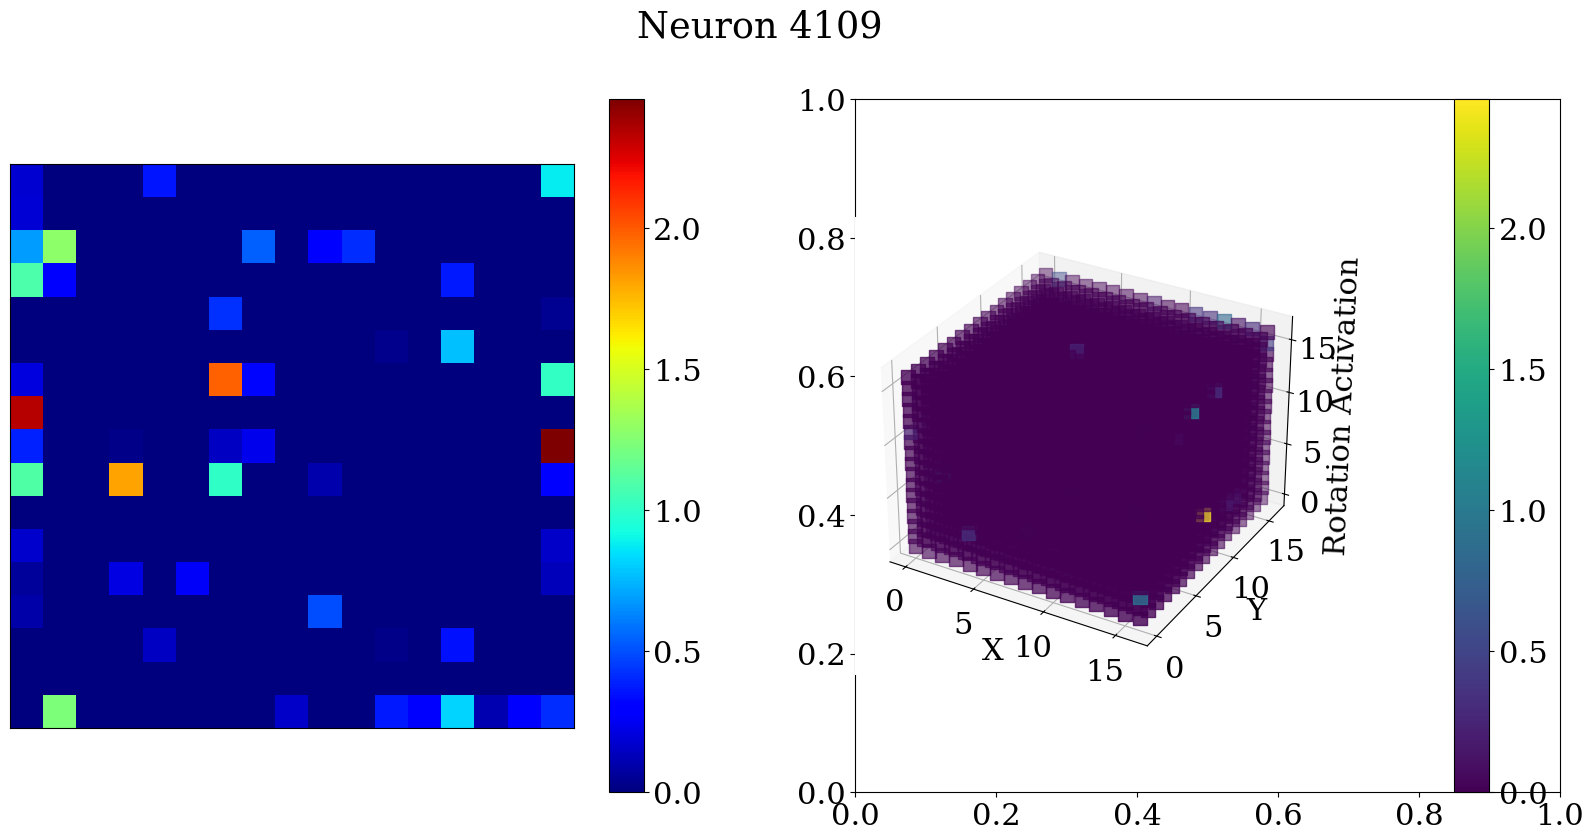

In [142]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt

import random

if env == 'biggest_world_r17':
    x_min = -20
    x_max = 20
    y_min = -30
    y_max = 35
else:
    x_min = 120
    y_min = 197
    x_max = 136
    y_max = 213

multiplier = 1

layer_name = 'vit_b16'
index_key = 'exclusive_place_cells_indices'

results_path = f'/home/mag/Space/results/{env}/2d/uniform/{model_name}'
unit_chart_info = np.load(f'{results_path}/inspect_units/unit_chart/{layer_name}/unit_chart.npy', allow_pickle=True)

n_bins = 17
n_rotations = 17

model_reps = np.load(f'{results_path}/{layer_name}/model_reps.npy').reshape((n_bins*n_bins, n_rotations, -1))

if model_reps.shape[1] > 8000:
    sampled_indices = np.load(f'/home/mag/Space/results/sample_indices_{model_name}_{layer_name}.npy')

indices = unit_indices_by_types[index_key]

idx = indices[5] 
print(f"Plotting 3d directional tuning figure for place cell with index {idx}")

heatmap = model_reps[:, :, idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

summed_heatmap = np.sum(heatmap, axis=1).reshape((n_bins, n_bins))
cmap = plt.get_cmap('jet').copy()
cmap.set_bad('gray', 1.)
im = ax1.imshow(summed_heatmap, cmap=cmap, interpolation='none')
plt.colorbar(im, ax=ax1)
ax1.set_xticks([])
ax1.set_yticks([])

data = heatmap.reshape((n_bins, n_bins, n_rotations))

x, y, z = np.meshgrid(np.arange(n_bins), np.arange(n_bins), np.arange(n_rotations))

x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()
data_flat = data.flatten()

ax2 = fig.add_subplot(122, projection='3d')
img = ax2.scatter(x_flat, y_flat, z_flat, c=data_flat, cmap=cm.viridis, marker='s', s=100)

plt.colorbar(img, ax=ax2, pad=0.2)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Rotation Activation')

fig.suptitle(f"Neuron {idx}")
plt.show()


In [164]:
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

layer_name = 'avg_pool'
index_key = 'exclusive_place_cells_indices'

save_path = f'figs/{env}/2d/uniform/{model_name}/marginal_tuning/{layer_name}_place_cells_oumc.pdf'
results_path = f'/home/mag/Space/results/{env}/2d/uniform/{model_name}'

model_reps = np.load(f'{results_path}/{layer_name}/model_reps.npy')

if model_reps.shape[1] > 8000:
    sampled_indices = np.load(f'/home/mag/Space/results/sample_indices_{model_name}_{layer_name}.npy')
    model_reps = model_reps[:, sampled_indices]

n_bins = 17
n_rotations = 17

#count = 0

with PdfPages(save_path) as pdf:
    for idx in tqdm(unit_indices_by_types[index_key]):
        #count += 1
        #if count > 150:
        #    break
        heatmap = model_reps[:, idx].reshape((n_bins, n_bins, n_rotations))
        x_marginal = np.sum(heatmap, axis=0)
        y_marginal = np.sum(heatmap, axis=1)

        summed_rotation_map = np.sum(heatmap, axis=2)
        
        fig, axs = plt.subplots(1, 3, figsize=(17, 5))
    
        img = axs[0].imshow(x_marginal, origin='lower', aspect='auto', extent=[0, n_bins, 0, n_rotations], cmap='hot')
        fig.colorbar(img, ax=axs[0], label='Marginal Unit Activation')
        axs[0].set_xlabel('X Position')
        axs[0].set_ylabel('Rotation Index')
        
        img = axs[1].imshow(y_marginal, origin='lower', aspect='auto', extent=[0, n_bins, 0, n_rotations], cmap='hot')
        fig.colorbar(img, ax=axs[1], label='Marginal Unit Activation')
        axs[1].set_xlabel('Y Position')
        axs[1].set_ylabel('Rotation Index')

        img = axs[2].imshow(summed_rotation_map, extent=[0, n_bins, 0, n_bins],
                   origin='lower', aspect='auto', cmap='hot')
        fig.colorbar(img, label='Summed Unit Activation')
        axs[2].set_xlabel('X Position')
        axs[2].set_ylabel('Y Position')

        fig.suptitle(f'Neuron {idx}', fontsize=12)
        
        plt.tight_layout(h_pad=3.0)
        pdf.savefig(fig)
        plt.close(fig)


100%|███████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [06:43<00:00,  3.79it/s]


In [23]:
def _compute_single_location_directional_scores(activation_maps, location_idx):
    """
    Args:
        `activation_maps` corresponds to the un-summed activation maps
        for a single unit across rotations (n_locations, n_rotations)
        `location_idx` is the index of the location for which we want
        to compute the directional tuning.

    Returns:
        Directional score (mean vector length) and per-rotation vector lengths
        for the specific location.
    """
    # indexing into the unrolled map
    location_activation_map = activation_maps[location_idx]  # (n_rotations,)
    
    num_bins = location_activation_map.shape[0]  # n_rotations
    alphas = np.linspace(0, 2 * np.pi, num=num_bins, endpoint=False)
    betas = location_activation_map  # just this location instead of averaging

    polar_plot_coords = []  # (n_rotations, 2)
    per_rotation_vector_length = []

    for alpha_i, beta_i in zip(alphas, betas):
        polar_plot_coords.append(
            [beta_i * np.cos(alpha_i), beta_i * np.sin(alpha_i)]
        )
        per_rotation_vector_length.append(
            np.linalg.norm([beta_i * np.cos(alpha_i), beta_i * np.sin(alpha_i)])
        )
    
    # Compute mean vector length
    r_normed_by_beta = np.sum(
        np.array(polar_plot_coords), axis=0) / np.sum(betas)

    mean_vector_length = np.linalg.norm(r_normed_by_beta)

    mean_angle = np.arctan2(r_normed_by_beta[1], r_normed_by_beta[0])
    
    # Convert mean_angle to the range [0, 2*pi]
    if mean_angle < 0:
        mean_angle += 2 * np.pi

    return mean_vector_length, per_rotation_vector_length, mean_angle

def plot_polar(ax, theta, per_rotation_vector_length, mean_vector_length):
    # Plot polar plot
    if mean_vector_length > 0.47:
        line_color = 'red'
        ax.spines['polar'].set_color('red')  # Change the spine color
    else:
        line_color = 'blue'
        ax.spines['polar'].set_color('blue')  # Default color for spine
        
    x = theta.tolist() + [theta[0]]
    y = per_rotation_vector_length + [per_rotation_vector_length[0]]
    ax.plot(x, y)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_thetagrids([0, 90, 180, 270], labels=['0', '90', '180', '270'])

### Generate pdfs of individual location polar plots

In [24]:
def generate_heatmap_and_polar_plots_pdf(activation_maps, save_path):
    """
    Args:
        `activation_maps`: The activation maps for a neuron across all locations and rotations.
        Save the heatmap and polar plots for each location in a single PDF.
    """
    num_locations = activation_maps.shape[0]  # n_locations
    num_rotations = activation_maps.shape[1]  # n_rotations
    
    # Set up a grid for heatmap dimensions
    grid_x = int(np.sqrt(num_locations))  # Assuming the grid is square
    grid_y = grid_x
    
    with PdfPages(save_path) as pdf:
        # Create a figure for the heatmap
        fig = plt.figure(figsize=(8, 8))
        ax1 = fig.add_subplot(111)
        
        # Plot the heatmap
        heatmap = np.sum(activation_maps, axis=1).reshape((grid_x, grid_y))
        cmap = plt.get_cmap('jet').copy()
        cmap.set_bad('gray', 1.)
        im = ax1.imshow(heatmap, cmap=cmap, interpolation='none')
        plt.colorbar(im, ax=ax1)
        ax1.set_title("Neuron Activation Heatmap")
        ax1.set_xticks([])
        ax1.set_yticks([])
        
        # Save the heatmap page
        pdf.savefig(fig)
        plt.close(fig)
        
        # Set up angles for the polar plots
        theta = np.linspace(0, 2*np.pi, num_rotations, endpoint=False)
        
        # Now generate polar plots, 10 per page (5 rows, 2 columns)
        for i in range(0, num_locations, 10):
            fig = plt.figure(figsize=(10, 12))  # Adjust size if needed
            gs = gridspec.GridSpec(5, 2, hspace=0.5, wspace=0.4)  # 5 rows, 2 columns

            for j in range(10):
                if i + j >= num_locations:
                    break  # Ensure we don't go out of bounds

                location_idx = i + j
                ax = fig.add_subplot(gs[j // 2, j % 2], projection='polar')
                
                # Compute the directional tuning for the specific location
                mean_vector_length, per_rotation_vector_length, _ = _compute_single_location_directional_scores(activation_maps, location_idx)
                
                # Plot the polar plot for the location
                plot_polar(ax, theta, per_rotation_vector_length, mean_vector_length)

            # Save the page with 10 polar plots
            
            pdf.savefig(fig)
            plt.close(fig)
            
    print(f"PDF saved at {save_path}")


In [25]:
def generate_heatmap_and_polar_plots_pdf(activation_maps, save_path):
    """
    Args:
        `activation_maps`: The activation maps for a neuron across all locations and rotations.
        Save the heatmap and polar plots for each location in a single PDF.
    """
    num_locations = activation_maps.shape[0]  # n_locations
    num_rotations = activation_maps.shape[1]  # n_rotations
    
    # Set up a grid for heatmap dimensions
    grid_x = int(np.sqrt(num_locations))  # Assuming the grid is square
    grid_y = grid_x
    
    with PdfPages(save_path) as pdf:
        # Create a figure for the heatmap
        fig = plt.figure(figsize=(8, 8))
        ax1 = fig.add_subplot(111)
        
        # Plot the heatmap
        heatmap = np.sum(activation_maps, axis=1).reshape((grid_x, grid_y))
        cmap = plt.get_cmap('jet').copy()
        cmap.set_bad('gray', 1.)
        im = ax1.imshow(heatmap, cmap=cmap, interpolation='none')
        plt.colorbar(im, ax=ax1)
        ax1.set_title("Neuron Activation Heatmap")
        ax1.set_xticks([])
        ax1.set_yticks([])
        
        # Save the heatmap page
        pdf.savefig(fig)
        plt.close(fig)
        
        # Set up angles for the polar plots
        theta = np.linspace(0, 2*np.pi, num_rotations, endpoint=False)
        
        # Now generate polar plots, 10 per page (5 rows, 2 columns)
        for i in range(0, num_locations, 10):
            fig = plt.figure(figsize=(10, 12))  # Adjust size if needed
            gs = gridspec.GridSpec(5, 2, hspace=0.5, wspace=0.4)  # 5 rows, 2 columns

            for j in range(10):
                if i + j >= num_locations:
                    break  # Ensure we don't go out of bounds

                location_idx = i + j
                ax = fig.add_subplot(gs[j // 2, j % 2], projection='polar')
                
                # Compute the directional tuning for the specific location
                mean_vector_length, per_rotation_vector_length, _ = _compute_single_location_directional_scores(activation_maps, location_idx)
                
                # Plot the polar plot for the location
                plot_polar(ax, theta, per_rotation_vector_length, mean_vector_length)

            # Save the page with 10 polar plots
            
            pdf.savefig(fig)
            plt.close(fig)
            
    print(f"PDF saved at {save_path}")

def generate_heatmaps_and_directional_maps_pdf(heatmaps, save_path):
    """
    Args:
        `activation_maps`: The activation maps for a neuron across all locations and rotations.
        Save the heatmap and polar plots for each location in a single PDF.
    """
    num_locations = heatmaps[0].shape[0]  # n_locations
    num_rotations = heatmaps[0].shape[1]  # n_rotations
    
    # Set up a grid for heatmap dimensions
    grid_x = int(np.sqrt(num_locations))  # Assuming the grid is square
    grid_y = grid_x
    
    with PdfPages(save_path) as pdf:
        for i, heatmap in enumerate(heatmaps): #TODO swap axis of heatmaps
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

            # First heatmap
            heatmap1 = np.sum(heatmap, axis=1).reshape((grid_x, grid_y))
            cmap1 = plt.get_cmap('jet').copy()
            cmap1.set_bad('gray', 1.)
            im1 = ax1.imshow(heatmap1, cmap=cmap1, interpolation='none')
            plt.colorbar(im1, ax=ax1)
            ax1.set_title("Neuron Activation Heatmap")
            ax1.set_xticks([])
            ax1.set_yticks([])

            # Collect rotational info for all locations in the plot
            mean_vector_lengths = np.zeros(num_locations) 
            mean_direction = np.zeros(num_locations)
            for location_idx in range(num_locations):
                mean_vector_length, per_rotation_vector_length, mean_angle = _compute_single_location_directional_scores(heatmap, location_idx)
                mean_vector_lengths[location_idx] = mean_vector_length
                mean_direction[location_idx] = mean_angle
            
            heatmap2 = mean_direction.reshape((grid_x, grid_y))  # Assuming a second heatmap with the same shape
            cmap2 = plt.get_cmap('jet').copy()
            cmap2.set_bad('gray', 1.)
            im2 = ax2.imshow(heatmap2, cmap=cmap2, interpolation='none')
            plt.colorbar(im2, ax=ax2)
            ax2.set_title("Neuron Directional Tuning")
            ax2.set_xticks([])
            ax2.set_yticks([])

            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)
                
        print(f"PDF saved at {save_path}")
    

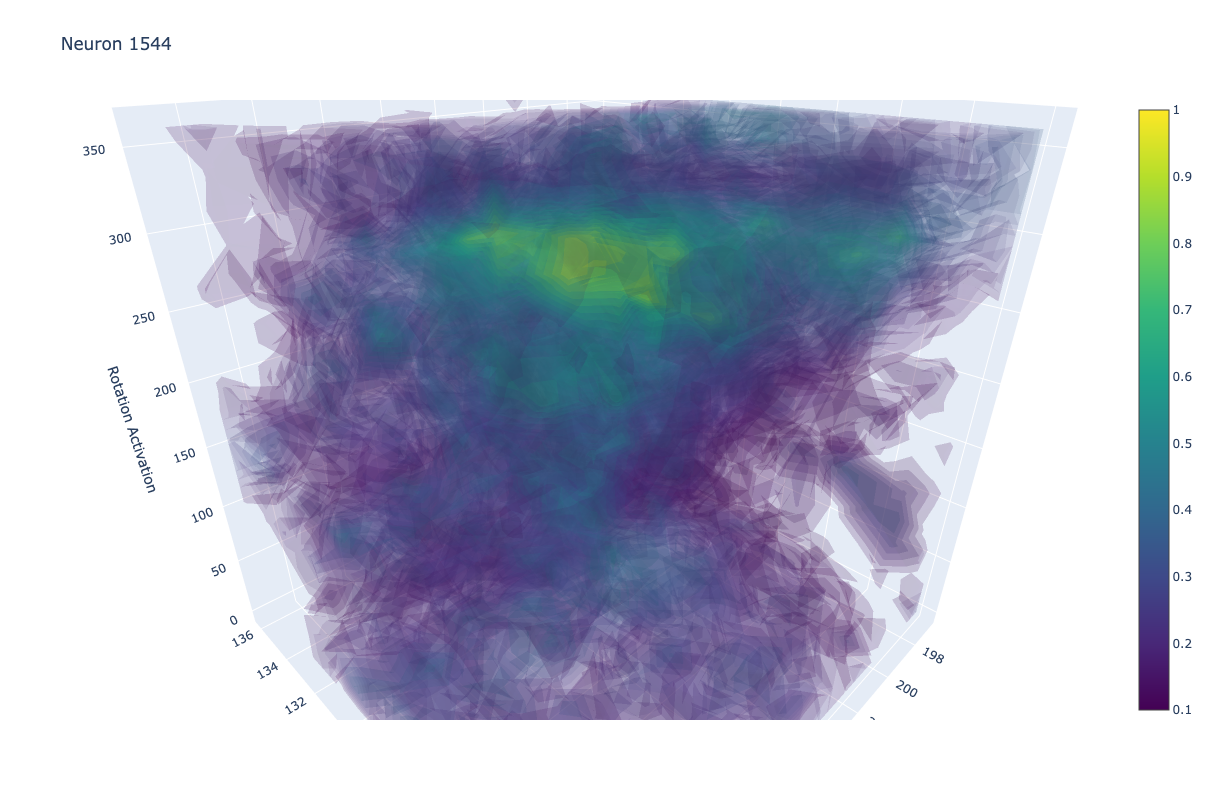

In [48]:
import numpy as np
import plotly.graph_objects as go

x, y, z = np.meshgrid(
    np.linspace(x_min, x_max, n_bins),
    np.linspace(y_min, y_max, n_bins),
    np.linspace(0, 360, n_rotations)  # Assuming rotations range from 0 to 360 degrees
)

x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()
data_flat = data.flatten()

fig = go.Figure(data=go.Volume(
    x=x_flat,
    y=y_flat,
    z=z_flat,
    value=data_flat,
    opacity=0.1,  # Adjust opacity to see through the volume
    isomin=0.1,   # Minimum data value to visualize
    isomax=1.0,   # Maximum data value to visualize
    surface_count=20,  # Number of isosurfaces
    colorscale='Viridis'
))

# Update layout for better visualization
fig.update_layout(
    title=f"Neuron {idx}",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Rotation Activation',
        xaxis=dict(nticks=10),
        yaxis=dict(nticks=10),
        zaxis=dict(nticks=10),
    ),
    width=800,
    height=800
)

# Display the interactive plot
fig.show()


In [ ]:
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages

if env == 'biggest_world_r17':
    x_min = -20
    x_max = 20
    y_min = -30
    y_max = 35
else:
    x_min = 120
    y_min = 197
    x_max = 136
    y_max = 213

multiplier = 1

layer_name = 'avg_pool'
index_key = 'exclusive_place_cells_indices'

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

results_path = f'/home/mag/Space/results/{env}/2d/uniform/{model_name}'
unit_chart_info = np.load(f'{results_path}/inspect_units/unit_chart/{layer_name}/unit_chart.npy', allow_pickle=True)

model_reps = np.load(f'{results_path}/{layer_name}/model_reps.npy')
model_reps = model_reps.reshape(model_reps.shape[0] // 17, 17, -1)

indices = unit_indices_by_types[index_key]

idx = indices[155]
print(f"Saving pdf for place cell with index {idx}")

heatmap = model_reps[:, :, indices]

#save_path = f'/home/mag/Space/figs/cell_plots/{env}/{model_name}/{layer_name}/place_cell_{idx}.pdf'
save_path = f'/home/mag/Space/figs/cell_plots/{env}/{model_name}/{layer_name}/place_cell_directional_tuning.pdf'

#generate_heatmap_and_polar_plots_pdf(heatmap, save_path)
generate_heatmaps_and_directional_maps_pdf(heatmap.transpose(2,0,1), save_path)

## Interative plot

In [70]:
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages

if env == 'biggest_world_r17':
    x_min = -20
    x_max = 20
    y_min = -30
    y_max = 35
else:
    x_min = 120
    y_min = 197
    x_max = 136
    y_max = 213

multiplier = 1

layer_name = 'conv5_block2_out'
index_key = 'exclusive_place_cells_indices'

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

results_path = f'/home/mag/Space/results/{env}/2d/uniform/{model_name}'
unit_chart_info = np.load(f'{results_path}/inspect_units/unit_chart/{layer_name}/unit_chart.npy', allow_pickle=True)

model_reps = np.load(f'{results_path}/{layer_name}/model_reps.npy')
model_reps = model_reps.reshape(model_reps.shape[0] // 17, 17, -1)

indices = unit_indices_by_types[index_key]

idx = indices[45]
print(f"Plotting 3d directional tuning figure for place cell with index {idx}")

heatmap = model_reps[:, :, idx]
num_locations = heatmap.shape[0]

# Generate mean angle preferences and mean vector length for each location
mean_vector_lengths = np.zeros(num_locations) 
mean_direction = np.zeros(num_locations)
for location_idx in range(num_locations):
    mean_vector_length, per_rotation_vector_length, mean_angle = _compute_single_location_directional_scores(heatmap, location_idx)
    mean_vector_lengths[location_idx] = mean_vector_length
    mean_direction[location_idx] = mean_angle

#mean_vector_lengths = np.nan_to_num(mean_vector_lengths)
#mean_direction = np.nan_to_num(mean_vector_lengths)


Plotting 3d directional tuning figure for place cell with index 6793


/tmp/ipykernel_2129623/530865040.py:32: RuntimeWarning:

invalid value encountered in divide



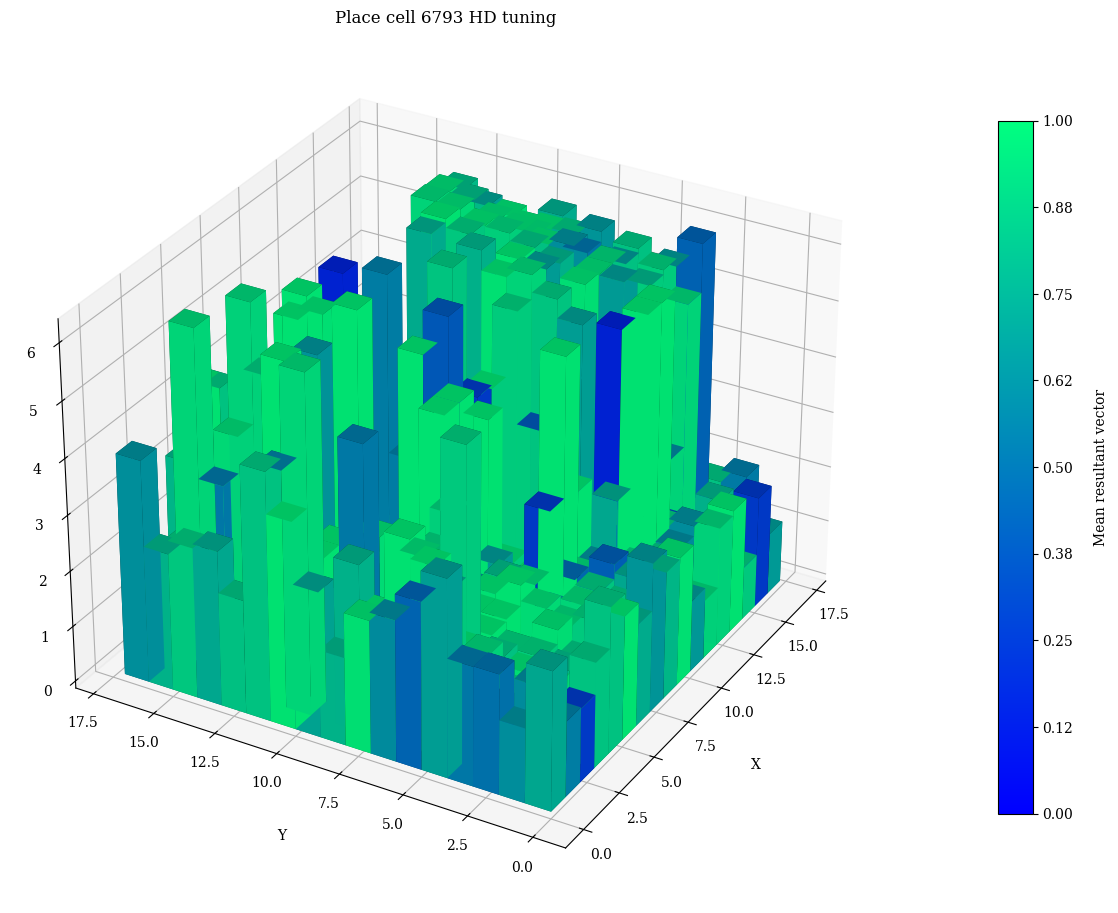

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

grid_len = int(np.sqrt(num_locations))
X = np.arange(grid_len)
Y = np.arange(grid_len)
X, Y = np.meshgrid(X, Y)
Z = mean_direction.reshape((grid_len, grid_len))

x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()

color_dimension = mean_vector_lengths.flatten()

cmap = plt.cm.winter.copy()
cmap.set_bad(color='gray')

norm = mcolors.Normalize(vmin=0, vmax=1)

m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fcolors = m.to_rgba(color_dimension)

z_flat_clean = np.nan_to_num(z_flat, nan=0)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x_flat, y_flat, np.zeros_like(z_flat_clean), 1, 1, z_flat_clean, color=fcolors, shade=True)

ax.set_xlabel('X', labelpad=15)
ax.set_ylabel('Y', labelpad=15)
ax.set_zlabel('Mean direction (radians)', labelpad=15)
ax.set_title(f'Place cell {idx} HD tuning')

m.set_array([])
cbar = plt.colorbar(m, ax=ax, pad=0.1, shrink=0.6)
#cbar.set_label('Mean direction (radians)', labelpad=15)
cbar.set_label('Mean resultant vector', labelpad=15)

ticks = np.linspace(0, 1, num=9)
#ticks = np.linspace(0, 2*np.pi, num=9)
cbar.set_ticks(ticks)
tick_labels = [f"{t:.2f}" for t in ticks]
cbar.set_ticklabels(tick_labels)

ax.view_init(elev=30, azim=210)

# Show the plot
plt.savefig(f'figs/{env}/2d/uniform/{model_name}/place_hd_tuning/{layer_name}/{index_key}/{idx}.png', dpi=300)
plt.show()


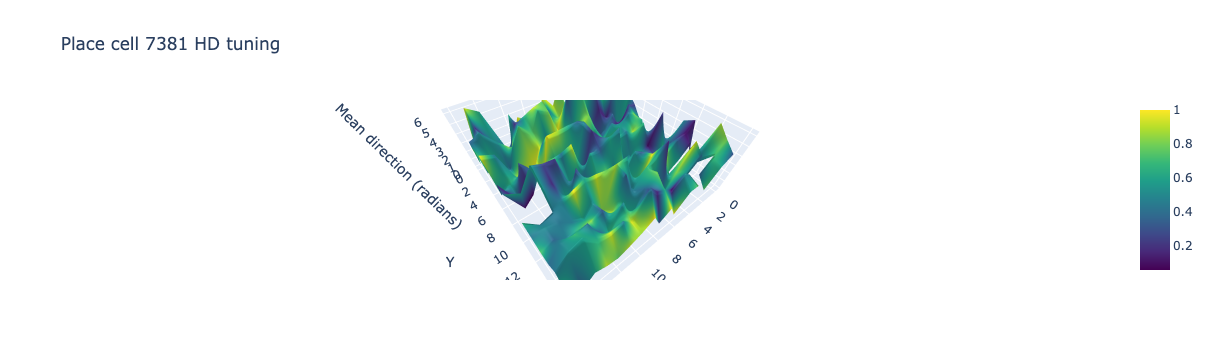

In [77]:
import numpy as np
import plotly.graph_objects as go

grid_len = int(np.sqrt(num_locations))
X = np.arange(grid_len)
Y = np.arange(grid_len)
X, Y = np.meshgrid(X, Y)
Z = mean_direction.reshape((grid_len, grid_len))

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, surfacecolor=mean_vector_lengths.reshape(grid_len, grid_len), colorscale='Viridis')])

fig.update_layout(
    title=f'Place cell {idx} HD tuning',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Mean direction (radians)',
    ),
    coloraxis_colorbar=dict(
        title="Mean resultant vector"
    )
)

fig.show()

